# Figure 4

> Simulated evolution of the terrestrial planets' orbits, approximately 5 Myr before the tip of the Sun's RGB phase.  Similar to Fig. 2, subplot **(a)** shows the Sun's pre-TRGB mass loss.  Subplot **(b)** compares the semi-major axes of Mercury (gray), Venus (olive), Earth (blue), and Mars (orange), with and without tidal effects present (dashed and solid lines respectively).

## Load

We first load in the extracted data, exported from MESA log files, as done in [mesa2txt.ipynb](https://github.com/sabaronett/REBOUNDxPaper/blob/master/mesa2txt.ipynb).

In [1]:
import numpy as np

data = np.loadtxt('m.txt')    # return (N, 2) array
mtimes = data[:, 0]           # return only 1st col
masses = data[:, 1]           # return only 2nd col

data = np.loadtxt('r.txt')
rtimes = data[:, 0]
Rsuns = data[:, 1]            # data in Rsun units

radii = np.zeros(Rsuns.size)  # convert Rsun to AU
for i, r in enumerate(Rsuns):
    radii[i] = r * 0.00465047 # 215 Rsun ~ 1 AU

## Setup #1 (No Tides)

Next we set up the Sun and all four terrestrial planets, first *without* loading the `time_constant_time_lag` REBOUNDx force.

In [2]:
import rebound
import reboundx

M0 = 0.8868357536545315 # initial mass of star
names = ['Sun', 'Mercury', 'Venus', 'Earth', 'Mars']
symbols = ['☉', '☿', '♀︎', '⊕', '♂︎']

def tidesim(tides = False):
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')
    sim.add(m=M0, hash=names[0])
    sim.add(m=0.166e-6, a=0.39, hash=names[1])
    sim.add(m=2.45e-6, a=0.723, hash=names[2])
    sim.add(m=3.e-6, a=1., hash=names[3])
    sim.add(m=0.323e-6, a=1.524, hash=names[4])
    sim.integrator = 'whfast'
    sim.dt = 0.1*sim.particles[1].P
    sim.move_to_com()
    rebx = reboundx.Extras(sim)
    if tides:
        tides = rebx.load_force("tides_constant_time_lag")
        rebx.add_force(tides)
        return sim, rebx, tides
    return sim, rebx

Now we can create an `Interpolator` object for each parameter set and pass the corresponding arrays as arguments.

In [3]:
sim, rebx = tidesim()
starmass = reboundx.Interpolator(rebx, mtimes, masses, 'spline')
starradius = reboundx.Interpolator(rebx, rtimes, radii, 'spline')

# update Sun's mass and radius accordingly
ps = sim.particles
T0 = 12388.5e6 # Sun's age ~ 5 Myr pre-TRGB (sim start)
ps[0].m = starmass.interpolate(rebx, t=T0)
ps[0].r = starradius.interpolate(rebx, t=T0)
sim.move_to_com()

## Run #1 (No Tides)

We integrate for 5 Myr, updating the central body's mass and radius interpolated at the time between outputs.

In [4]:
%%time
Nout = 1000
mass = np.zeros(Nout)
radius = np.zeros(Nout)
a = np.zeros([Nout, sim.N])
ts = np.linspace(0., 5.e6, Nout)
cp = 1                             # index of closest survivng planet
emass = 0.                         # mass of engulfed planets

for i, time in enumerate(ts):
    sim.integrate(time)
    d = ps[0] - ps[cp]             # componentwise difference to nearest planet
    r = np.sqrt(d.x**2 + d.y**2 + d.z**2)
    
    if r <= ps[0].r:               # nearest planet engulfed
        emass += ps[cp].m          # add engulfed planet mass
        ps[cp].m = 0               # zero planet mass and move to COM
        ps[cp].x, ps[cp].y, ps[cp].z = 0, 0, 0
        cp += 1                    # next closest surviving planet
        sim.dt = 0.1*ps[cp].P      # adjust timestep accordingly
    
    # evolve Sun and recenter to COM
    ps[0].m = starmass.interpolate(rebx, t=T0+sim.t) + emass
    ps[0].r = starradius.interpolate(rebx, t=T0+sim.t)
    sim.move_to_com()
    
    # record values for post-sim plots
    mass[i] = sim.particles[0].m
    radius[i] = sim.particles[0].r
    for j in range(1, sim.N):
        a[i, j] = ps[j].a

/home/stanley/miniconda3/envs/rebx-3.1.0/lib/python3.8/site-packages/rebound/simulation.py:675: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 2min 12s, sys: 17.3 ms, total: 2min 12s
Wall time: 2min 12s


## Setup #2 (With Tides)

The convective friction time is

\begin{equation}
t_f = \left(\dfrac{MR^2}{L}\right)^{1/3}.
\tag{1}
\end{equation}

We can calculate the values of $t_f(t)$ for the Sun's evolution in advance as all the parameters are already known . Offloading this calculation before the simulation's start helps reduce extra math operations in between timesteps.

Our expression for Hut's constant time lag is

\begin{equation}
\tau = \dfrac{2R^3}{GMt_f}.
\tag{2}
\end{equation}

Similarly, we can precalculate $\tau$ into its own "prefactor."

In [5]:
data = np.loadtxt('l.txt')
ltimes = data[:, 0]
Lsuns = data[:, 1]                  # data in Lsun units

watts = np.zeros(Lsuns.size)        # convert Lsun to W (MKS units)
for i, l in enumerate(Lsuns):
    watts[i] = l * 3.828e26         # IAU Resolution B3 conversion

lumins = np.zeros(watts.size)       # convert W to sim units
for i, w in enumerate(watts):
    lumins[i] = (w * ((6.7e-12)**2) * (5e-31)) / ((3.2e-8)**3)

t_fs = np.zeros(lumins.size)        # precalculate t_f (Eq. 1)
for i, l in enumerate(lumins):
    t_fs[i] = np.cbrt(masses[i]*radii[i]**2/l)
    
taus = np.zeros(t_fs.size)          # precalc tau (Eq. 2)
G = 4*np.pi**2                      # units of AU, yrs and solar masses
for i, t_f in enumerate(t_fs):
    taus[i] = 2.*radii[i]**3/G/masses[i]/t_f

We now recreate the simulation, this time loading the `time_constant_time_lag` REBOUNDx force.

In [6]:
sim, rebx, tides = tidesim(tides = True)
starmass = reboundx.Interpolator(rebx, mtimes, masses, 'spline')
starradius = reboundx.Interpolator(rebx, rtimes, radii, 'spline')
startau = reboundx.Interpolator(rebx, ltimes, taus, 'spline')

# update Sun's mass and radius accordingly
ps = sim.particles
ps[0].m = starmass.interpolate(rebx, t=T0)
ps[0].r = starradius.interpolate(rebx, t=T0)
sim.move_to_com()

We specify the primary and secondaries' equilibrium gravitational response to the tidal field acting on them through the `tctl_k1` apsidal motion constant, equal to half the tidal Love number $k_2$. According to Zahn (1989), $\lambda_2 \approx k_1$.

If we give the primary a physical radius, then any (massive) orbiting body will raise equilibrium tides on the primary.

In [7]:
ps[0].params["tctl_k1"] = 0.038 # ~ lambda_2, Schroder & Smith (2008)

If we additionally set the `tctl_tau` constant time lag parameter, this delayed response introduces dissipation, which will typically cause eccentricity damping, and will migrate the orbiting bodies either inward or outward depending on whether they orbit faster or slower than the spin of the tidally deformed body. We set the spin rate of each body with the `Omega` parameter. If it is not set, `Omega` is assumed to be zero.

We note that this implementation assumes bodies' spins are fixed, so consider whether more angular momentum is being changed in the system than is available in the spins! We additionally assume that bodies spins are aligned with the reference z axis.

In [8]:
ps[0].params["tctl_tau"] = startau.interpolate(rebx, t=T0)
ps[0].params["Omega"] = 0 # explicitly set to 0 (would be 0 by default)

## Run #2 (With Tides)

We again integrate for 5 Myr, updating the central body's mass and radius, as well as its `tctl_tau` parameter, interpolated at the time between outputs.

In [9]:
%%time
atides = np.zeros([Nout, sim.N])
cp = 1                             # index of closest survivng planet
emass = 0.                         # mass of engulfed planets

for i, time in enumerate(ts):
    sim.integrate(time)
    d = ps[0] - ps[cp]             # componentwise difference to nearest planet
    r = np.sqrt(d.x**2 + d.y**2 + d.z**2)
    
    if r <= ps[0].r:               # nearest planet engulfed
        emass += ps[cp].m          # add engulfed planet mass
        ps[cp].m = 0               # zero planet mass and move to COM
        ps[cp].x, ps[cp].y, ps[cp].z = 0, 0, 0
        cp += 1                    # next closest surviving planet
        sim.dt = 0.1*ps[cp].P      # adjust timestep accordingly
    
    # evolve Sun, update tidal parameter, and recenter to COM
    ps[0].m = starmass.interpolate(rebx, t=T0+sim.t) + emass
    ps[0].r = starradius.interpolate(rebx, t=T0+sim.t)
    ps[0].params["tctl_tau"] = startau.interpolate(rebx, t=T0+sim.t)
    sim.move_to_com()
    
    # record values for post-sim plots
    for j in range(1, sim.N):
        atides[i, j] = ps[j].a

CPU times: user 2min 45s, sys: 10 ms, total: 2min 45s
Wall time: 2min 45s


## Plot

We plot the Sun's mass over time, and a comparison of the Sun's radius and terrestrial planets' semi-major axes over time, adjacent to one another.

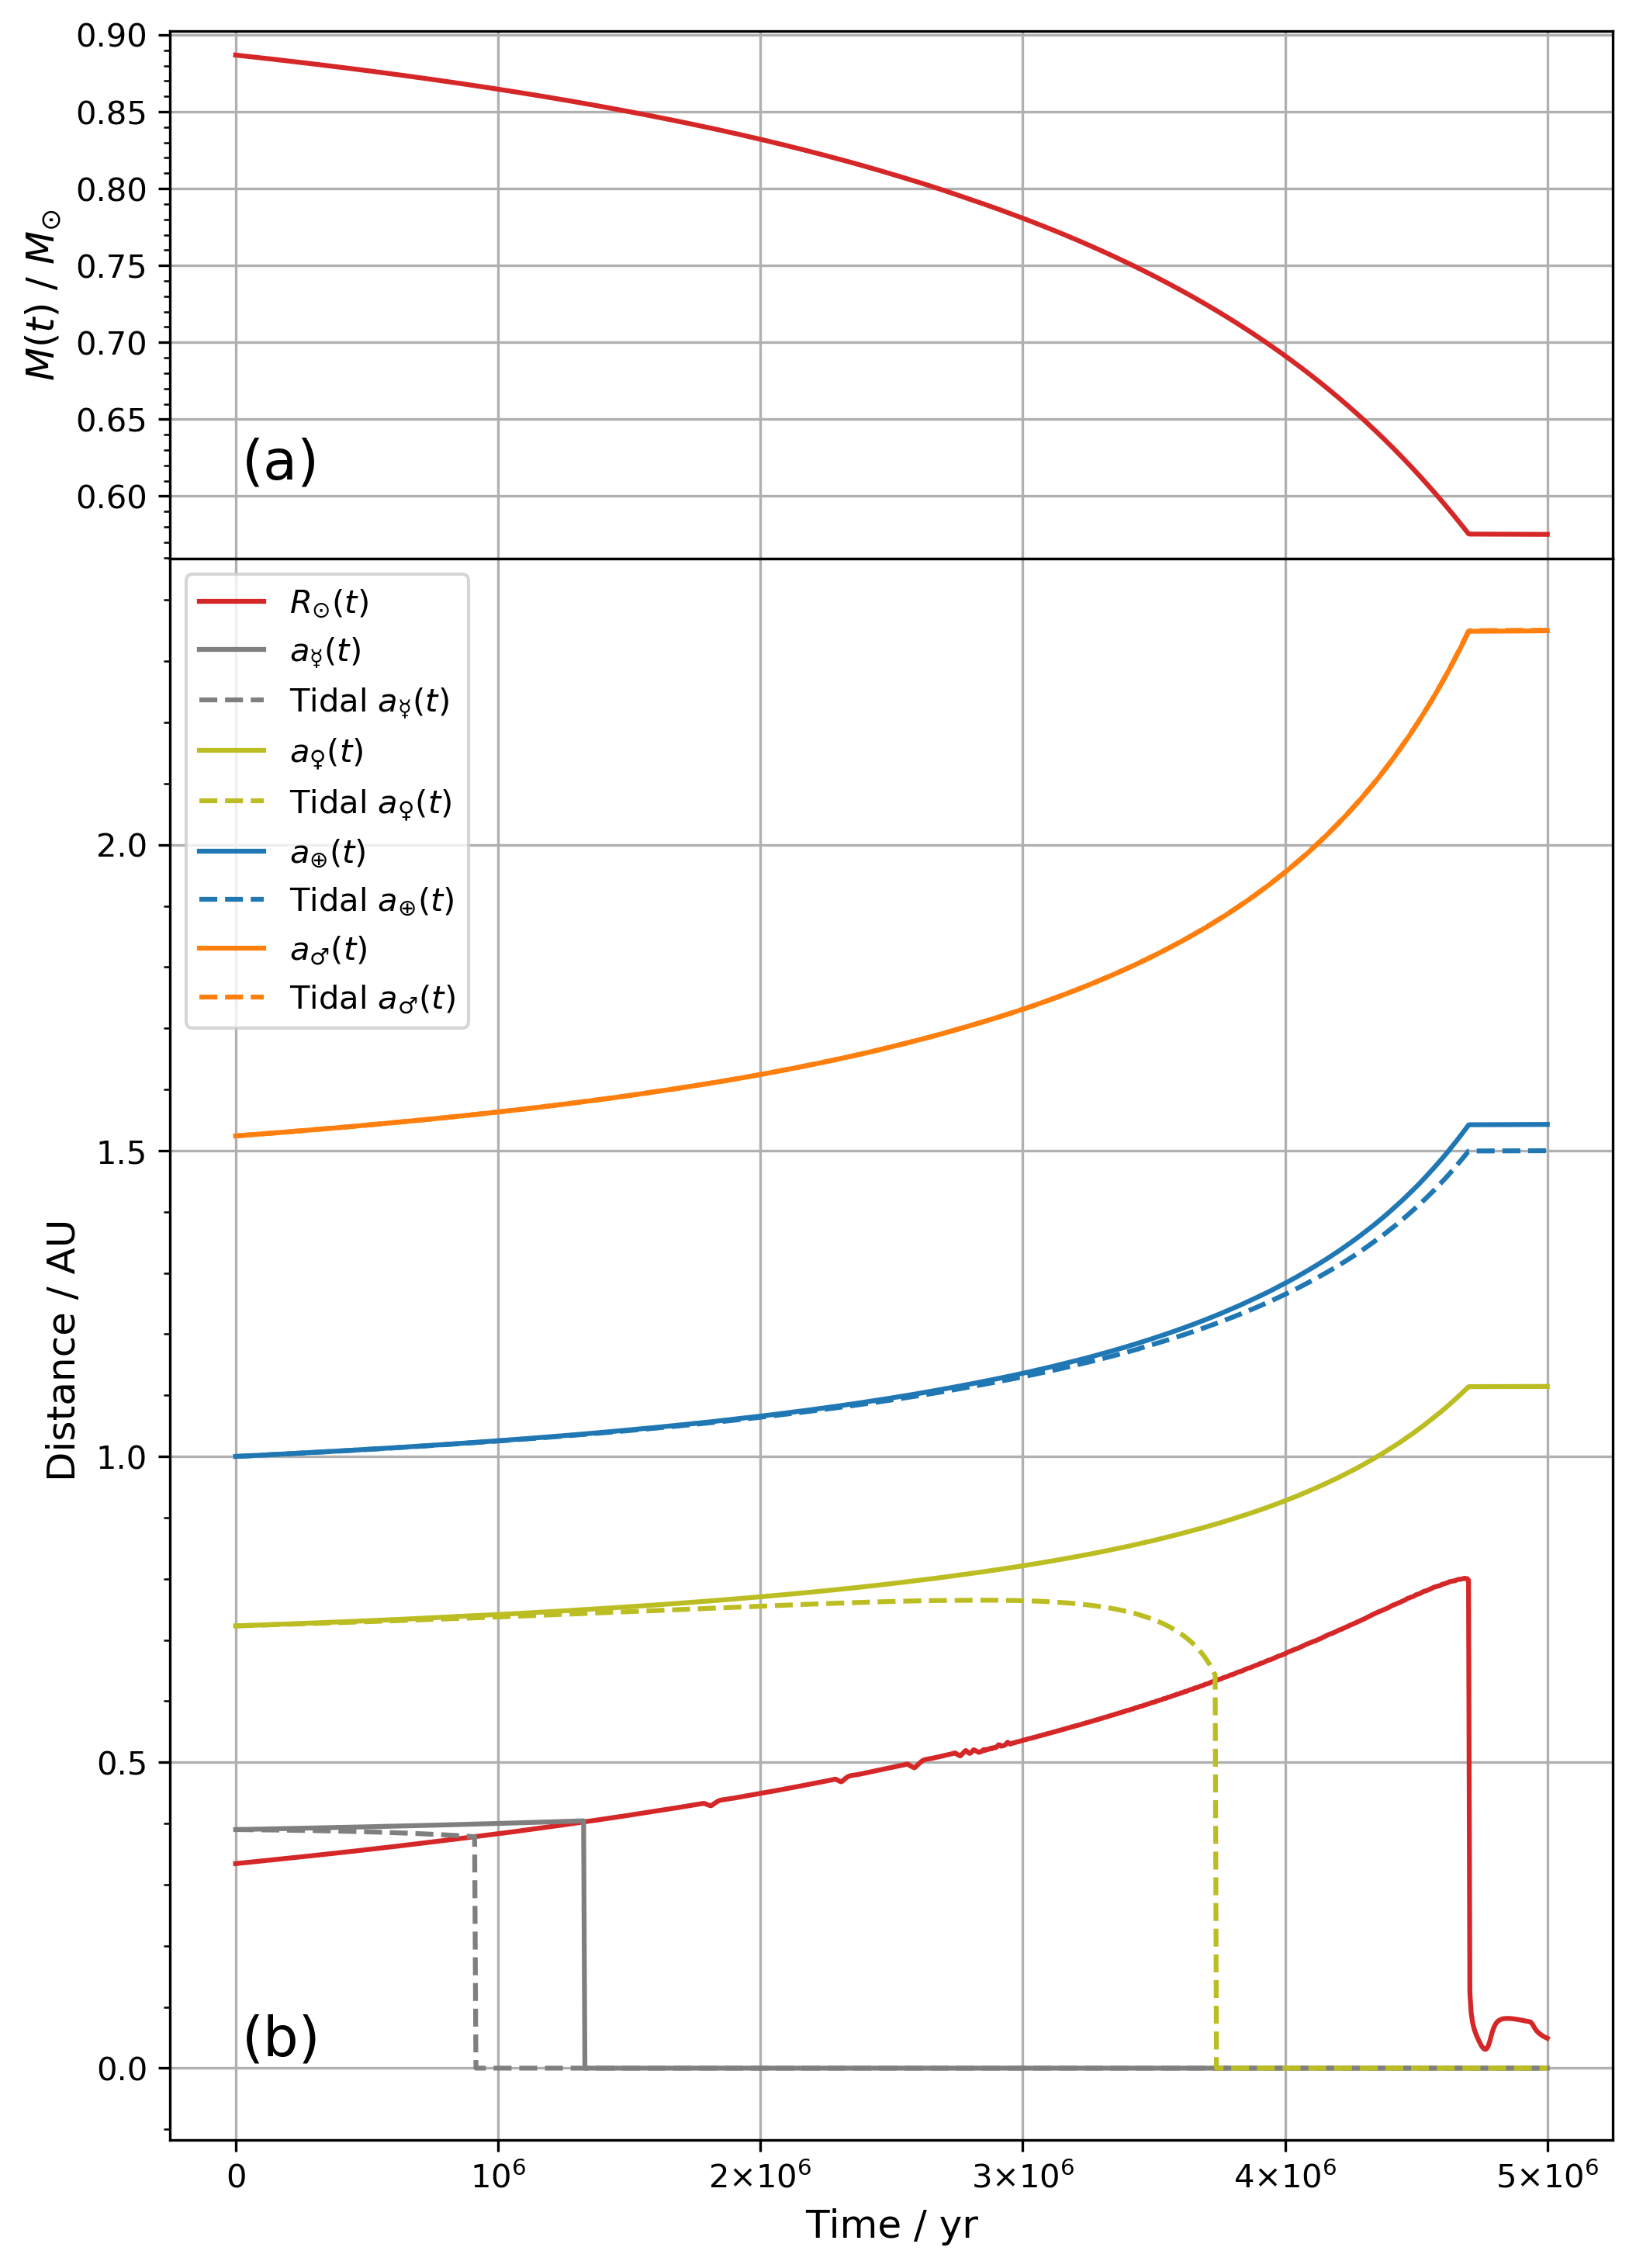

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
symbols = ['☉', '☿', '♀︎', '⊕', '♂︎']
colors = ['tab:red', 'tab:gray', 'tab:olive', 'tab:blue', 'tab:orange',]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 12),
                               dpi=300, gridspec_kw={'height_ratios': [1, 3]})
fig.subplots_adjust(hspace=0)

ax1.set_ylabel("$M(t)$ / $M_{\odot}$", fontsize='large')
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.plot(ts,mass, color='tab:red')
ax1.text(0.05, 0.23, '(a)', transform=ax1.transAxes, fontsize='xx-large',
        verticalalignment='top')
ax1.grid()

ax2.set_xlabel('Time / yr', fontsize='large')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.set_ylabel('Distance / AU', fontsize='large')
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.plot(ts,radius, color='tab:red', label='$R_{\odot}(t)$')
for i in range(1, sim.N):
    label = '$a_{%s}(t)$'%(symbols[i])
    ax2.plot(ts,a[:, i], color=colors[i], label=label)
    label = 'Tidal $a_{%s}(t)$'%(symbols[i])
    ax2.plot(ts,atides[:, i], '--', color=colors[i], label=label)
ax2.legend(loc='best')
ax2.text(0.05, 0.08, '(b)', transform=ax2.transAxes, fontsize='xx-large',
        verticalalignment='top')
ax2.grid()

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.savefig('img/fig4.png')